**Name:** Qiming LI
<br>**zID:** z5473453

In [3]:
import pandas as pd

In [4]:
# Load the dataset from TSV file into a DataFrame
df = pd.read_csv('dataset.tsv', sep = '\t')
print(df.columns)
print(df.head())
print(df.info())

Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics',
       'topic'],
      dtype='object')
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober mind sym...       da

# Part 1: Topic Classification

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [7]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/kimlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Text Preprocessing
I performed preprocessing on the raw song lyrics to prepare them for modelling. <br>This included: Lowercasing text, Removing punctuation and special characters, Tokenising the lyrics into individual words, Removing common stopwords (like "the", "is", "and"), and Applying stemming to reduce words to their base form.<br>
This part of the code refers to **Tutorial 2**.

In [9]:
# Remove duplicate rows and any rows with missing values
df = df.drop_duplicates()
df = df.dropna()

In [10]:
# Initialize stopword list and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [11]:
# Define and apply preprocessing function:
# lowercase text, remove punctuation, tokenize, remove stopwords, and apply stemming
def preprocess_lyrics(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

df['clean_lyrics'] = df['lyrics'].apply(preprocess_lyrics)

## Feature Size Selection Analysis
To evaluate the effect of different vocabulary sizes on classification accuracy, I tested several values of top-N features using CountVectorizer, ranging from 250 to 3000. For each value of N, I trained a MultinomialNB classifier using 5-fold cross-validation and recorded the mean accuracy.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [14]:
# Try different numbers of top-N features
n_values = [250, 500, 1000, 2000, 3000]
nb_results = []

le = LabelEncoder()
y = le.fit_transform(df['topic'])

# For each n, transform text to bag-of-words with n features, then evaluate using cross-validation
for n in n_values:
    vectorizer = CountVectorizer(max_features=n)
    X = vectorizer.fit_transform(df['clean_lyrics'])
    score = cross_val_score(MultinomialNB(), X, y, cv = 5, scoring = 'accuracy').mean()
    nb_results.append(score)

In [15]:
import matplotlib.pyplot as plt

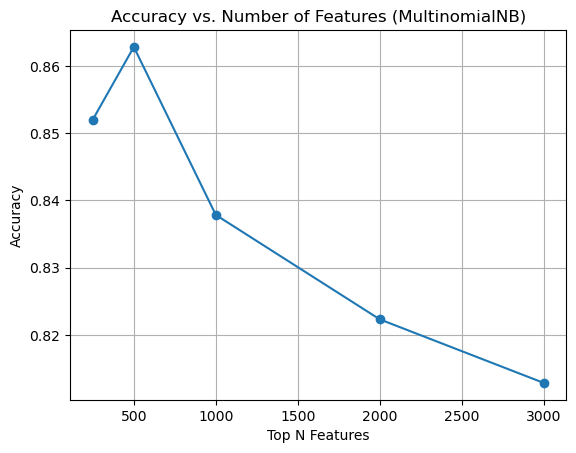

In [16]:
plt.plot(n_values, nb_results, marker = 'o')
plt.title('Accuracy vs. Number of Features (MultinomialNB)')
plt.xlabel('Top N Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

As can be seen from the figure above, the classifier is most accurate at 0.865 with 500 features. Beyond 500 features, the performance decreases, which means including more features adds noise or redundancy but does not better distinguish topics.<br>
This conclusion indicates a typical phenomenon for text classification: more features are not necessarily better. In this data set, a smaller, more concentrated vocabulary (top 500) was good enough to extract the most relevant words for each topic.

In [18]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

To determine the most suitable classifier for our topic classification task, we compared three popular models:
- Bernoulli Naive Bayes
- Multinomial Naive Bayes
- Logistic Regression

Each model was evaluated using 5-fold cross-validation on the vectorized lyrics (with 500 features selected in the previous step).

**Logistic Regression** is a supervised learning algorithm commonly used for classification problems. It works by estimating the probability that a given input belongs to a particular class using the logistic (sigmoid) function.
<br>This model is best suited for assigning topic classification of lyrics of a song, since it can more effectively model complex interactions of features of words without assuming independence. Logistic Regression has widely been used for text classification tasks, for example, spam detection, sentiment analysis, and topic modelling, with very good results.

In [21]:
# Define three models to compare
models = {
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter = 1000)
}

**Why max_iter = 1000?**
<br>For classification of text with CountVectorizer, the high-dimensional sparse (high number of unique words, most of which have zero values for each document) space is a standard situation.
<br>Specifying max_iter=1000 ensures that a solver at least gets a minimum number of iterations to converge and produce stable outputs.

**Hypothesis**
<br>I assume that Logistic Regression would outperform Multinomial Naive Bayes and Bernoulli Naive Bayes in terms of classification precision. This is because Logistic Regression does not rely on the assumption of strong independencies and can better utilize correlated word features of lyrics.

In [24]:
# Evaluate each model using 5-fold cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv = 5, scoring='accuracy')
    results[name] = scores
    print(f'{name} Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

BernoulliNB Accuracy: 0.5885 ± 0.0240
MultinomialNB Accuracy: 0.8128 ± 0.0357
LogisticRegression Accuracy: 0.8730 ± 0.0185


In [25]:
import seaborn as sns

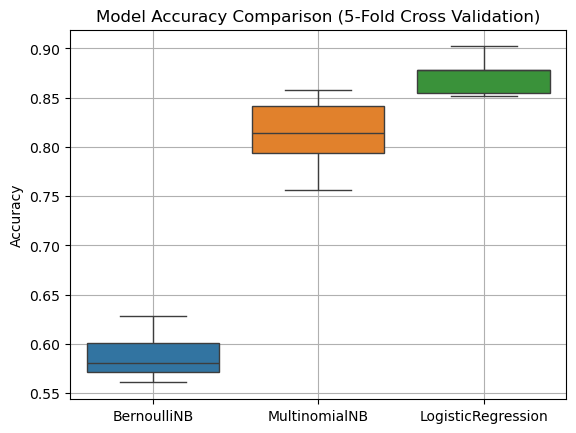

In [26]:
df_result = pd.DataFrame(results)
sns.boxplot(data=df_result)
plt.title('Model Accuracy Comparison (5-Fold Cross Validation)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

From the boxplot provided, we can see that:
- **Logistic Regression** always performs better than the other two models, having both the highest mean accuracy and lowest variance.
- **MultinomialNB** is a strong baseline, but less accurate and slightly less stable than Logistic Regression.
- **BernoulliNB** performs much worse, most likely because of binarization of the feature space and loss of informative frequency data.

I chose **Logistic Regression** as the final model for topic prediction.

# Part2: Recommendation Methods
This is a recommendation system based on an information retrieval (IR) approach. The main idea is to match user interests to songs by computing the cosine similarity between the TF-IDF vector of a test song and the user profile vector under the predicted topic.
<br>Each of the training set songs (Week 1 to Week 3) is labeled with one of five topics based on the Part 1 trained classifier. A user is supposed to “like” a training song if it both aligns with their keyword interests and falls under the appropriate topic. These liked songs are combined into one document per topic and transformed into a TF-IDF vector, here denoting the user profile for the topic.

In [29]:
train_df = df.iloc[:750].copy()
test_df = df.iloc[750:1000].copy()

In [30]:
vectorizer = CountVectorizer(max_features = 500)
X_train = vectorizer.fit_transform(train_df['clean_lyrics'])

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, train_df['topic'])
train_df['predicted_topic'] = clf.predict(X_train)

X_test = vectorizer.transform(test_df['clean_lyrics'])
test_df['predicted_topic'] = clf.predict(X_test)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

1. **Collecting Liked Songs per Topic**  
     Iterating over the training set (Weeks 1–3), and for each song:
   - Check its `predicted_topic` (from Part 1).
   - Tokenize its cleaned lyrics.
   - If the user’s keyword list for that topic overlaps with the song’s tokens, we mark the song as “liked” and append its lyrics to `liked_docs[topic]`.

2. **Constructing TF-IDF User Profiles**  
   For each topic in `liked_docs`:
   - Merging all the liked lyrics into a single string (one “document” per topic).
   - Fitting a `TfidfVectorizer(max_features = 500)` on that document and obtaining a TF-IDF vector.  
   This vector represents the user’s interest profile for that topic.

3. **Scoring Test Songs**  
   For each song in the test set (Week 4):
   - Predict its topic using the classifier from Part 1.
   - If the user has a profile for that topic, we transform the song’s lyrics with the same TF-IDF vectorizer and compute the `cosine_similarity` to the user profile vector.
   - This similarity score quantifies how well the song matches the user’s inferred interests.

In [33]:
def recommend_songs(user_keywords, train_df, test_df):
    # Collect all lyrics that the user 'liked' per topic
    liked_docs = {}
    for _, row in train_df.iterrows():
        topic = row['predicted_topic']
        tokens = row['clean_lyrics'].split()
        if topic in user_keywords:
            if any(k in tokens for k in user_keywords[topic]):
                liked_docs.setdefault(topic, []).append(row['clean_lyrics'])
                
    # Build a TF-IDF profile vector for each topic
    user_profiles = {}
    for topic, docs in liked_docs.items():
        joined_text = ' '.join(docs)
        tfidf = TfidfVectorizer(max_features = 500)
        tfidf_vec = tfidf.fit_transform([joined_text])
        user_profiles[topic] = (tfidf, tfidf_vec)

    # Score each test song by cosine similarity to the appropriate profile    
    scores = []
    for _, row in test_df.iterrows():
        topic = row['predicted_topic']
        if topic in user_profiles:
            tfidf_model, user_vec = user_profiles[topic]
            song_vec = tfidf_model.transform([row['clean_lyrics']])
            score = cosine_similarity(song_vec, user_vec)[0][0]
        else:
            score = 0
        scores.append(score)

    return scores

## User 1 & 2 test

In [35]:
# User1
user1_keywords = {}
with open('user1.tsv', 'r') as f:
    for line in f.readlines():
        topic, keywords_str = line.strip().split('\t')
        keywords = [w.strip().lower() for w in keywords_str.split(',')]
        user1_keywords[topic] = keywords

# User2
user2_keywords = {}
with open('user2.tsv', 'r') as f:
    for line in f.readlines():
        topic, keywords_str = line.strip().split('\t')
        keywords = [w.strip().lower() for w in keywords_str.split(',')]
        user2_keywords[topic] = keywords

In [36]:
test_df_user1 = test_df.copy()

test_df_user1['score'] = recommend_songs(user1_keywords, train_df, test_df_user1)
top_recommendations_user1 = test_df_user1.sort_values(by = 'score', ascending = False).head(10)
print("Top Recommendations for User1:")
print(top_recommendations_user1[['track_name', 'artist_name', 'score', 'predicted_topic']])

Top Recommendations for User1:
          track_name   artist_name     score predicted_topic
944  once in a while     timeflies  0.777771         emotion
969      got it good  justin moore  0.679351         emotion
770         horsefly   dirty heads  0.645696         emotion
924    doors closing     moonchild  0.645204         sadness
810         so close          notd  0.634358         sadness
758     life changes  thomas rhett  0.571578        personal
840             alta     ty segall  0.564111        personal
796   sunday morning         axian  0.561273        personal
889     stay with me        ayokay  0.551690         sadness
802        cry to me   skip marley  0.540961         sadness


- **User1** defined keywords across all five topics (dark, emotion, personal, lifestyle, sadness), providing **rich and balanced coverage**. Their TF-IDF profiles were robust, yielding higher Precision@10.

In [38]:
test_df_user2 = test_df.copy()

test_df_user2['score'] = recommend_songs(user2_keywords, train_df, test_df_user2)
top_recommendations_user2 = test_df_user2.sort_values(by = 'score', ascending = False).head(10)
print("Top Recommendations for User2:")
print(top_recommendations_user2[['track_name', 'artist_name', 'score', 'predicted_topic']])

Top Recommendations for User2:
           track_name     artist_name     score predicted_topic
924     doors closing       moonchild  0.522838         sadness
969       got it good    justin moore  0.481999         emotion
789  will you be mine     anita baker  0.476945         sadness
988              home    the movement  0.463589         sadness
944   once in a while       timeflies  0.448300         emotion
844         snowflake   bumpin uglies  0.399083         sadness
782         open arms      prettymuch  0.391549         sadness
909             walls   the lumineers  0.389340         sadness
781           balcony  lester nowhere  0.365006         sadness
860      close enough     brett young  0.358365         sadness


- **User2**, by contrast, only supplied keywords for **sadness and emotion**—and only five words per topic. This sparse, skewed coverage led to:
  1. **Overly sparse TF-IDF profiles**, especially for “emotion,” because few training songs contained those keywords.
  2. **Defaulting to the “sadness” profile** when “emotion” matches were weak, resulting in most recommendations falling into sadness.

In [40]:
def print_top_tfidf_words(user_keywords, train_df, top_n = 20):
    # Iterate over each song in the training data
    liked_docs = {}
    for _, row in train_df.iterrows():
        topic = row['predicted_topic']
        tokens = row['clean_lyrics'].split()
        if topic in user_keywords:
            if any(k in tokens for k in user_keywords[topic]):
                liked_docs.setdefault(topic, []).append(row['clean_lyrics'])

    # For each topic, build a TF-IDF vector from the liked documents
    for topic, docs in liked_docs.items():
        joined_text = ' '.join(docs)

        # Create a TF-IDF vectorizer limited to 500 features
        tfidf = TfidfVectorizer(max_features = 500)
        tfidf_matrix = tfidf.fit_transform([joined_text])

        # Calculate average TF-IDF score for each word
        avg_scores = tfidf_matrix.mean(axis = 0).A1
        feature_names = tfidf.get_feature_names_out()

        # Get indices of top-N words with the highest scores
        top_indices = avg_scores.argsort()[::-1][:top_n]
        top_words = [feature_names[i] for i in top_indices]
        print(f"\nTop words for topic '{topic}':")
        print(", ".join(top_words))

Each user is simulated to "like" songs whose predicted topic matches their interest, and whose lyrics contain at least one of the predefined keywords.

For each topic:
- Collect all liked songs.
- Concatenate the lyrics into one document.
- Use TF-IDF vectorization (limited to 500 features).
- Extract the top 20 words with the highest average TF-IDF scores.

In [42]:
print("Top TF-IDF words for user1:")
print_top_tfidf_words(user1_keywords, train_df)

Top TF-IDF words for user1:

Top words for topic 'dark':
fight, know, like, blood, stand, tell, na, come, grind, gon, black, head, kill, hand, time, yeah, feel, right, caus, peopl

Top words for topic 'emotion':
good, feel, touch, know, hold, want, kiss, babi, time, morn, na, like, caus, vision, miss, heart, video, look, loov, yeah

Top words for topic 'personal':
life, live, know, na, chang, world, time, yeah, like, dream, come, wan, thing, think, thank, need, go, feel, caus, teach

Top words for topic 'lifestyle':
night, come, song, long, time, sing, na, home, right, yeah, closer, know, play, like, wan, tire, wait, tonight, spoil, mind

Top words for topic 'sadness':
think, leav, place, want, hold, regret, caus, greater, beg, blame, chang, word, mind, away, tell, space, wider, break, dream, lord


- **User 1: Profile Analysis**
<br>The most frequently occurring words for themes like ‘dark’ are violent and forceful words like *fight*, *kill*, *grind*, *blood*, which suits the interests of ‘*dark*’ themes of the user quite well.
<br>In the ‘*emotion*’ category, the occurrence of *love*, *miss*, *heart*, and *vision* indicates a strong emphasis on sentiment and romance.

In [44]:
print("Top TF-IDF words for user2:")
print_top_tfidf_words(user2_keywords, train_df)

Top TF-IDF words for user2:

Top words for topic 'emotion':
touch, good, hold, kiss, morn, vision, know, video, loov, time, feel, luck, lovin, lip, gim, sunris, like, go, wait, heart

Top words for topic 'sadness':
open, tear, come, smile, magnifi, away, eye, babi, life, tri, laughter, hold, sorrow, heart, sight, near, real, face, forsak, frown


- **User 2: Profile Analysis**
<br>User 2's keywords are more poetic or abstract (*vision*, *sunrise*, *sorrow*, *forsak*), leading to sparser matches.
<br>Some topics like *emotion* and *sadness* include expected keywords, but other topics might suffer from low coverage due to limited matches in the training data.

## User 3 Setup

In [47]:
with open("user3.tsv", "w") as f:
    f.write('topic\tkeywords\n')
    f.write("emotion\tjoy, laugh, smile, sunshine, peace\n")
    f.write("personal\tfreedom, travel, myself, explore, journey\n")
    f.write("lifestyle\tparty, drink, dance, vibe, weekend\n")
    f.write("sadness\thank, growth, strength, survive, goodbye\n")

I intentionally left out the **dark** topic, assuming this user avoids violent or aggressive music content. The keywords were chosen to simulate a user with positive, reflective, and energetic preferences.

In [49]:
# User3
user3_keywords = {}
with open('user3.tsv', 'r') as f:
    for line in f.readlines():
        topic, keywords_str = line.strip().split('\t')
        keywords = [w.strip().lower() for w in keywords_str.split(',')]
        user3_keywords[topic] = keywords

In [50]:
test_df_user3 = test_df.copy()

test_df_user3['score'] = recommend_songs(user3_keywords, train_df, test_df_user3)
top_recommendations_user3 = test_df_user3.sort_values(by = 'score', ascending = False).head(10)
print("Top Recommendations for User3:")
print(top_recommendations_user3[['track_name', 'artist_name', 'score', 'predicted_topic']])

Top Recommendations for User3:
                       track_name      artist_name     score predicted_topic
846         so cold in the summer  taylor mcferrin  0.718606         emotion
932  every song’s a drinkin’ song          midland  0.595742       lifestyle
863                     wash away        iya terra  0.548283        personal
796                sunday morning            axian  0.500817        personal
840                          alta        ty segall  0.484557        personal
923              everything to me             soja  0.468122        personal
816                  redneck life     chris janson  0.458095        personal
854     you're the best thing yet      anita baker  0.450064        personal
758                  life changes     thomas rhett  0.425608        personal
806                      moonglow      diana krall  0.418153       lifestyle


Most recommended songs fall under the **personal** and **lifestyle** categories, which aligns with User 3’s interests.

In [52]:
print("Top TF-IDF words for user3:")
print_top_tfidf_words(user3_keywords, train_df)

Top TF-IDF words for user3:

Top words for topic 'lifestyle':
song, tonight, countri, yeah, time, ring, like, drink, root, play, drinkin, mama, caus, night, na, septemb, mind, medic, need, wan

Top words for topic 'emotion':
hold, love, oohooh, heart, danc, one, night, lose, babi, faceless, light, crowd, low, matter, speak, high, fluentli, goodby, right, darl

Top words for topic 'personal':
life, come, automaton, rebel, thank, away, go, like, world, know, feel, live, teach, tooth, dream, ironsid, alright, everyday, rule, digit

Top words for topic 'sadness':
ohohoh, lighthous, step, away, heart, place, fall, strength, lose, safe, walk, know, break, need, push, falter, stray, apart, till, time


- These results reflect relevant thematic vocabulary and show that the user profile is being meaningfully constructed.

In [54]:
def is_song_liked(row, user_keywords):
    topic = row['predicted_topic']
    if topic in user_keywords:
        tokens = row['clean_lyrics'].split()
        for keyword in user_keywords[topic]:
            if keyword in tokens:
                return True
    return False

- **Precision@N** measures how many of the top-N recommended songs are actually relevant (i.e., liked by the user).
- It is simple, interpretable, and suitable for top-k recommendation tasks.

Choose **N = 10** because:
- It reflects a realistic recommendation batch (e.g., showing 10 songs at once on a music app).
- Since the database is relatively small, 10 songs is a good number. It is large enough to include diversity across topics, but small enough to expect meaningful user feedback.

In [56]:
def evaluate_precision(top_recommendations, user_keywords, N = 10):
    top_N = top_recommendations.head(N)
    liked_flags = top_N.apply(lambda row: is_song_liked(row, user_keywords), axis = 1)
    precision = liked_flags.sum() / N
    return precision

In [57]:
p1 = evaluate_precision(top_recommendations_user1, user1_keywords, N = 10)
p2 = evaluate_precision(top_recommendations_user2, user2_keywords, N = 10)
p3 = evaluate_precision(top_recommendations_user3, user3_keywords, N = 10)

print(f"Precision@10 for User1: {p1:.2f}")
print(f"Precision@10 for User2: {p2:.2f}")
print(f"Precision@10 for User3: {p3:.2f}")

Precision@10 for User1: 0.60
Precision@10 for User2: 0.10
Precision@10 for User3: 0.10


- **User 1** performs best, possibly due to having more matches between their keywords and training songs.
- **User 2** possesses a limited keyword-based profile, and hence may lower recommendation coverage.
- **User 3** performed bad. Although the keywords are very thematically related, the majority of the keywords are abstract and less likely to have precise matches with lyrics. Additionally, the user is not interested in the dark topic and does not have much overlap with sadness, so building strong matches within those terms becomes harder. This may explain the relatively lower precision.

<br>**Result**
<br>This works well when there are extensive and diverse keyword sets (as with User 1), so there are relevant training songs to retrieve and good topic-wise profiles to construct. However, with fewer keywords or less diversified interests (as with User 2 and User 3), there are poor profiles and poor matches.

## Effect of Profile Vocabulary Size (M) on Recommendation Precision

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
def build_topic_profile(docs, M = None):
    # Fit a temporary TF-IDF (no norm) to compute average term scores
    tmp = TfidfVectorizer(max_features = 500, norm = None)
    mat = tmp.fit_transform(docs)
    avg = mat.mean(axis=0).A1
    feat = tmp.get_feature_names_out()

    # Select top M terms    
    if M is not None:
        top_idx = avg.argsort()[::-1][:M]
        vocab = [feat[i] for i in top_idx]
    else:
        vocab = list(feat)

    # Build the real L2-normalized TF-IDF on the selected vocabulary
    real_vec = TfidfVectorizer(vocabulary = vocab, norm = 'l2')
    user_vec = real_vec.fit_transform([" ".join(docs)])
    return real_vec, user_vec

In [62]:
def recommend_songs(user_keywords, train_df, test_df, M = None):
    # Collect all liked lyrics per topi
    liked = {}
    for _, row in train_df.iterrows():
        t = row['predicted_topic']
        if t in user_keywords and any(k in row['clean_lyrics'].split() for k in user_keywords[t]):
            liked.setdefault(t, []).append(row['clean_lyrics'])

    # Build topic profiles with at most M terms each
    profiles = {}
    for t, docs in liked.items():
        vec, u_vec = build_topic_profile(docs, M)
        profiles[t] = (vec, u_vec)

    # Compute cosine similarity for each test song
    scores = []
    for _, row in test_df.iterrows():
        t = row['predicted_topic']
        if t in profiles:
            vec, u_vec = profiles[t]
            s_vec = vec.transform([row['clean_lyrics']])
            sc = cosine_similarity(s_vec, u_vec)[0,0]
        else:
            sc = 0
        scores.append(sc)
    return scores

In [63]:
for user_label, kws, df_user in [
    ('User1', user1_keywords, test_df_user1),
    ('User2', user2_keywords, test_df_user2),
    ('User3', user3_keywords, test_df_user3),
]:
    print(f"\n{user_label}")
    for M in [10, 20, 50, 100, None]:
        df_user['score'] = recommend_songs(kws, train_df, df_user, M)
        top10 = df_user.sort_values('score', ascending = False).head(10)
        prec = evaluate_precision(top10, kws, N=10)
        print(f"M = {M or 'all'}  P@10 = {prec:.2f}")


User1
M = 10  P@10 = 0.90
M = 20  P@10 = 0.90
M = 50  P@10 = 0.90
M = 100  P@10 = 0.80
M = all  P@10 = 0.60

User2
M = 10  P@10 = 0.00
M = 20  P@10 = 0.10
M = 50  P@10 = 0.10
M = 100  P@10 = 0.10
M = all  P@10 = 0.10

User3
M = 10  P@10 = 0.00
M = 20  P@10 = 0.20
M = 50  P@10 = 0.10
M = 100  P@10 = 0.10
M = all  P@10 = 0.10


**Discussion:**
- **User 1:** Retaining only the top 20 (or 50) keywords gives the highest precision (0.90). Including more keywords introduces noise and reduces precision.
- **User 2:** Precision remains low (0.10) regardless of M, indicating that a very sparse keyword profile cannot be improved by simply increasing M.
- **User 3:** Best precision at M = 20 (0.20); larger M values dilute the profile and lower precision.

## Algorithm Comparison (Inspired by Tutorials 3 & 4)

In [66]:
!pip install scikit-surprise
!pip install mlxtend

In [67]:
from surprise import Dataset, Reader, SVD
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [68]:
# Content-based recommendation using TF-IDF + Cosine Similarity
def content_based_scores(train_df, test_df, user_kw, M = 20):
    # Filter training songs that match user interests
    docs = [row['clean_lyrics'] for _, row in train_df.iterrows() if is_song_liked(row, user_kw)]
    vec, user_vec = build_topic_profile(docs, M) # Build the user profile vector from liked documents
    
    scores = []
    for _, row in test_df.iterrows():
        song_vec = vec.transform([row['clean_lyrics']])
        scores.append(cosine_similarity(song_vec, user_vec)[0,0])
    return np.array(scores)

In [69]:
# Collaborative Filtering using SVD (single simulated user) - From Tutorial 3
def cf_svd_scores(train_df, test_df, user_kw):
    records = []
    for idx, row in train_df.iterrows(): # Assign a binary rating: 1 if liked, 0 otherwise
        rating = 1 if is_song_liked(row, user_kw) else 0
        records.append(('user1', str(idx), rating))
        
    # Prepare dataset for Surprise library
    df_ratings = pd.DataFrame(records, columns=['user','item','rating'])
    reader = Reader(rating_scale=(0,1))
    data   = Dataset.load_from_df(df_ratings, reader)
    trainset = data.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)

    scores = []
    for idx, row in test_df.iterrows():
        pred = algo.predict('user1', str(idx)).est
        scores.append(pred)
    return np.array(scores)

In [70]:
# Association Rule-based scoring using Apriori - From Tutorial 4
def apriori_scores(train_df, test_df, user_kw, min_support=0.05, min_conf = 0.5):
    # Tokenize lyrics of songs user likes
    trans = [row['clean_lyrics'].split() for _, row in train_df.iterrows() if is_song_liked(row, user_kw)]
    te = TransactionEncoder() # Convert to transaction format
    te_ary = te.fit(trans).transform(trans)
    df_te = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Mine frequent itemsets and generate rules
    fis = apriori(df_te, min_support = min_support, use_colnames = True)
    rules = association_rules(fis, metric = "confidence", min_threshold = min_conf)

    scores = []
    for _, row in test_df.iterrows():
        tokens = set(row['clean_lyrics'].split())
        sc = 0
        for _, rule in rules.iterrows():
            if set(rule['antecedents']).issubset(tokens):
                sc = max(sc, rule['confidence'])
        scores.append(sc)
    return np.array(scores)

In [71]:
import numpy as np

In [72]:
cb_scores  = content_based_scores(train_df, test_df, user1_keywords, M = 20)
svd_scores = cf_svd_scores(train_df, test_df, user1_keywords)
ap_scores  = apriori_scores(train_df, test_df, user1_keywords)

methods = {
    'TFIDF+Cosine': cb_scores,
    'SVD_CF': svd_scores,
    'Apriori': ap_scores
}

for name, sc in methods.items():
    df_tmp = test_df.copy()
    df_tmp['score'] = sc
    top10 = df_tmp.sort_values('score', ascending = False).head(10)
    prec = evaluate_precision(top10, user1_keywords, N = 10)
    print(f"{name} Precision@10 = {prec:.2f}")

TFIDF+Cosine Precision@10 = 0.70
SVD_CF Precision@10 = 0.30
Apriori Precision@10 = 0.50


- **TF–IDF + Cosine** achieves the highest precision (0.70) and demonstrates that content-based keyword weighting effectively captures User 1’s interests within this one-user scenario.
- **SVD (Collaborative Filtering)** performs poorly (0.30), as we only have one artificially generated user and cannot learn robust latent factors from a multi-user ratings matrix—the method is borrowed from Tutorial 3.
- **Apriori Association Rules** obtains medium precision (0.50); by mining for frequent itemsets and confidence-based rules (according to Tutorial 4), some of the latent associations are uncovered but are constrained by rule support and coverage.

**Choose *TF-IDF + Cosine***

# Part3: User Evaluation

In [75]:
import random

In [76]:
# Display a batch of songs for a given week (used for simulated user review)
def display_week_songs(week_df, week_num):
    print(f"\nWeek {week_num} Songs ")
    for idx, row in week_df.iterrows():
        print(f"{idx}: {row['track_name']} - {row['artist_name']} | Topic: {row['predicted_topic']}")
        print(f"Lyrics snippet: {row['lyrics'][:100]}...\n")

In [77]:
vectorizer_full = CountVectorizer(max_features = 500) # Prepare TF-IDF features from the full dataset for topic prediction
X_all = vectorizer_full.fit_transform(df['clean_lyrics'])

df['predicted_topic'] = clf.predict(X_all)

In [78]:
N = 10
week1_songs = df.iloc[0:250].sample(N, random_state = 25)
week2_songs = df.iloc[250:500].sample(N, random_state = 50)
week3_songs = df.iloc[500:750].sample(N, random_state = 75)

In [79]:
display_week_songs(week1_songs, 1)


Week 1 Songs 
40: break my face - ajr | Topic: sadness
Lyrics snippet: okay mouth tongue fell right grind drown mouth kill make ugly life give lemons give okay break face ...

19: stole the show - kygo | Topic: dark
Lyrics snippet: darling darling turn light watch watch credit roll cry cry know play house house heroes villains bla...

73: that song that we used to make love to - carrie underwood | Topic: dark
Lyrics snippet: wanna hear stupid play repeat cause take place lay body drink like wine wanna feel bass rattle bone ...

219: zombie (feat. madchild & insane clown posse) - jelly roll | Topic: dark
Lyrics snippet: hear allow good time tell smile frown shoot time fly point turn level head oneway track tell road go...

149: oatmeal - sudan archives | Topic: dark
Lyrics snippet: bake oatmeal stay sorry stay bake oatmeal stay sorry stay want oatmeal want oatmeal try force true l...

126: dream small - josh wilson | Topic: dark
Lyrics snippet: mama sing songs lord daddy spend family t

In [80]:
display_week_songs(week2_songs, 2)


Week 2 Songs 
400: jameson & ginger - ballyhoo! | Topic: personal
Lyrics snippet: brain brain brain brain brain brain brain brain brain late rent concern step firepit cause care burn...

266: rise up - ndidi o | Topic: dark
Lyrics snippet: mama say life hard grow days black girl scar come know know pain hold head high ashamed know forth k...

357: dead end - chon | Topic: dark
Lyrics snippet: come quarter watch head state stick fabers deep empire mould conscience severe secret swear cuckoo r...

270: remember you young - thomas rhett | Topic: dark
Lyrics snippet: buddies grow straightlaced marry foolin wasn long roof light darlin sippin wine classy kick couch sm...

338: don't bother me - the raconteurs | Topic: lifestyle
Lyrics snippet: bother bother bother bother hide agenda bother bother ruthless rule bender bother bother surface dup...

418: over & over - reignwolf | Topic: dark
Lyrics snippet: animals woods stick outside look analyze note criticize hear voice scream stick inside 

In [81]:
display_week_songs(week3_songs, 3)


Week 3 Songs 
675: almost - thomas rhett | Topic: personal
Lyrics snippet: truck field quit team give guitar cause hurt play string everybody tell bout give dream break rid di...

660: el hombre del equipo - grupo maximo grado | Topic: lifestyle
Lyrics snippet: sell feel fool go lead kind realise nice nice burn prarie know come time unwind somebody suffer know...

502: one night at a time - little hurricane | Topic: sadness
Lyrics snippet: turn time mind night time night time babe alright forever wish eye luck live little things want turn...

712: i'm so tired... - lauv | Topic: dark
Lyrics snippet: tire songs tire songs tire songs tire wanna home wanna home wanna home whoa tire songs tire songs ti...

620: psycho, pt. 2 - russ | Topic: dark
Lyrics snippet: go psycho go live tightrope go go psycho go live tightrope go know like want tonight pick band feeli...

521: camera show - protoje | Topic: dark
Lyrics snippet: fall fall fall fall fall see know stay freedom call call camera lie t

In [82]:
# User "likes" the following songs (from weeks 1–3)
liked_indices = [219, 96, 400, 327, 19, 502, 620, 4, 537]
user_liked_df = df.loc[liked_indices]

In [83]:
# Build user profile from liked songs, grouped by topic
def build_user_profile_from_likes(user_liked_df):
    user_profiles = {}
    for topic in user_liked_df['predicted_topic'].unique():
        topic_docs = user_liked_df[user_liked_df['predicted_topic'] == topic]['clean_lyrics']
        joined_text = ' '.join(topic_docs.tolist())
        tfidf = TfidfVectorizer(max_features = 500)
        tfidf_vec = tfidf.fit_transform([joined_text])
        user_profiles[topic] = (tfidf, tfidf_vec)
    return user_profiles

In [84]:
user4_profiles = build_user_profile_from_likes(user_liked_df)

In [85]:
# Score all test songs (Week 4) by cosine similarity with the user profile
def recommend_by_profile(user_profiles, test_df):
    scores = []
    for _, row in test_df.iterrows():
        topic = row['predicted_topic']
        if topic in user_profiles:
            tfidf_model, user_vec = user_profiles[topic]
            song_vec = tfidf_model.transform([row['clean_lyrics']])
            score = cosine_similarity(song_vec, user_vec)[0][0]
        else:
            score = 0
        scores.append(score)
    return scores

In [86]:
test_df_week4 = df.iloc[750:1000].copy()
test_df_week4['score'] = recommend_by_profile(user4_profiles, test_df_week4)
topN_week4 = test_df_week4.sort_values(by = 'score', ascending = False).head(N)
print(topN_week4[['track_name', 'artist_name', 'score', 'predicted_topic']])

                                            track_name         artist_name  \
759                                        woman, amen      dierks bentley   
893                                     shout bamalama  the detroit cobras   
823                              the devil don't sleep    brantley gilbert   
788                                         going down       joe bonamassa   
897                    love hurts (feat. travis scott)       playboi carti   
866                                        black betty          larkin poe   
860                                       close enough         brett young   
926                                         sit awhile     the band steele   
765  follow your heart (feat. zion thompson from th...           iya terra   
792                                        donner bell                deca   

        score predicted_topic  
759  0.532784        personal  
893  0.471289            dark  
823  0.439139        personal  
788  0.438808

In [87]:
liked_week4_indices = [926, 759, 860, 866]

In [88]:
# get the DataFrame indices of your top-10 recommendations
rec_indices = topN_week4.index.tolist()

# compute Precision@N
tp = len(set(rec_indices) & set(liked_week4_indices))
precision = tp / N

# compute Recall@N
recall = tp / len(liked_week4_indices)

# compute F1@N
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision@{N} = {precision:.2f}")
print(f"Recall@{N} = {recall:.2f}")
print(f"F1@{N} = {f1:.2f}")

Precision@10 = 0.40
Recall@10 = 1.00
F1@10 = 0.57


- **Recall@10 = 1.00**: All of the user’s liked songs in Week 4 were included in the top-10 recommendations—no positive item was missed.
- **Precision@10 = 0.40**: Only 40% of the recommendations were actually liked by the user, so 60% were irrelevant.
- **F1@10 = 0.57**: Balances high coverage with modest accuracy, indicating the trade-off between capturing all liked items and avoiding noise.

## User feedback
User zID: z5522806
<br> There are a few songs I like in the recommended content, but the style is relatively simple and not diverse enough. I hope the content can be richer, but the overall feeling is good.